In [1]:
from PIL import Image, ImageOps
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Experimentacion 



# procesos de segmentacion v_2

## Función para segmentar la imagen basada en los rangos de color HSV.

#### version_3

In [2]:
rangos_colores = {
    "hoja_verde": [[(30, 30, 30), (90, 255, 255)]],
    "mancha_marron": [[(0, 20, 40), (30, 255, 255)],
                      [(160, 20, 20), (180, 255, 255)]]
}


In [3]:
# Función para mostrar imágenes
def mostrar_imagen(titulos, imagenes):
    fig, axs = plt.subplots(1, len(imagenes), figsize=(15, 5))  # Crear una fila con tantas imágenes como se necesiten
    for i, (titulo, imagen) in enumerate(zip(titulos, imagenes)):
        axs[i].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        axs[i].set_title(titulo)
        axs[i].axis('off')  # Ocultar los ejes
    plt.show()


In [4]:

def segmentar_colores(imagen_ruta, rangos_colores):
    # Cargar la imagen usando PIL
    imagen_pil = Image.open(imagen_ruta)
    
    # Convertir la imagen PIL a un array numpy compatible con OpenCV
    imagen = cv2.cvtColor(np.array(imagen_pil), cv2.COLOR_RGB2BGR)
    
    # Convertir la imagen a espacio de color HSV
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Crear máscara para eliminar el fondo gris
    gris_bajo = np.array([0, 0, 100])
    gris_alto = np.array([180, 30, 220])
    mascara_no_gris = cv2.inRange(imagen_hsv, gris_bajo, gris_alto)
    mascara_no_gris = cv2.bitwise_not(mascara_no_gris)
    
    resultados = {}
    mascaras = []
    
    titulos = ["Imagen Original"]
    imagenes = [imagen]

    for nombre_mascara, rangos in rangos_colores.items():
        mascara_combinada = np.zeros(imagen.shape[:2], dtype=np.uint8)
        for bajo, alto in rangos:
            mascara = cv2.inRange(imagen_hsv, np.array(bajo), np.array(alto))
            mascara_combinada = cv2.bitwise_or(mascara_combinada, mascara)
        
        # Aplicar la máscara de no-gris
        mascara_combinada = cv2.bitwise_and(mascara_combinada, mascara_no_gris)
        
        # Aplicar operaciones morfológicas
        kernel = np.ones((5,5), np.uint8)
        mascara_clean = cv2.morphologyEx(mascara_combinada, cv2.MORPH_OPEN, kernel)
        mascara_clean = cv2.morphologyEx(mascara_clean, cv2.MORPH_CLOSE, kernel)
        
        mascaras.append(mascara_clean)
        
        resultado = cv2.bitwise_and(imagen, imagen, mask=mascara_clean)
        resultados[nombre_mascara] = resultado
        
        titulos.append(f'Resultado {nombre_mascara}')
        imagenes.append(resultado)

    mascara_total = np.zeros(imagen.shape[:2], dtype=np.uint8)
    for mascara in mascaras:
        mascara_total = cv2.bitwise_or(mascara_total, mascara)
    
    # Encontrar el contorno más grande (asumiendo que es la hoja principal)
    contornos, _ = cv2.findContours(mascara_total, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contornos:
        contorno_max = max(contornos, key=cv2.contourArea)
        mascara_hoja = np.zeros(mascara_total.shape, np.uint8)
        cv2.drawContours(mascara_hoja, [contorno_max], -1, 255, -1)
        
        # Aplicar la máscara de la hoja principal
        mascara_total = cv2.bitwise_and(mascara_total, mascara_hoja)
    
    resultado_combinado = cv2.bitwise_and(imagen, imagen, mask=mascara_total)
    resultados["combinado"] = resultado_combinado

    titulos.append("Resultado Combinado")
    imagenes.append(resultado_combinado)

    mostrar_imagen(titulos, imagenes)
    
    return resultados

In [5]:
import random
import os

def procesar_imagenes_aleatorias1(carpeta_imagenes, rangos_colores, n=2):
    # Listar imágenes en la carpeta
    imagenes = [f for f in os.listdir(carpeta_imagenes) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Seleccionar n imágenes al azar
    imagenes_seleccionadas = random.sample(imagenes, min(n, len(imagenes)))

    # Procesar las imágenes
    resultados = []
    for imagen in imagenes_seleccionadas:
        input_image_path = os.path.join(carpeta_imagenes, imagen)
        resultados.append(segmentar_colores(input_image_path, rangos_colores))

    return resultados

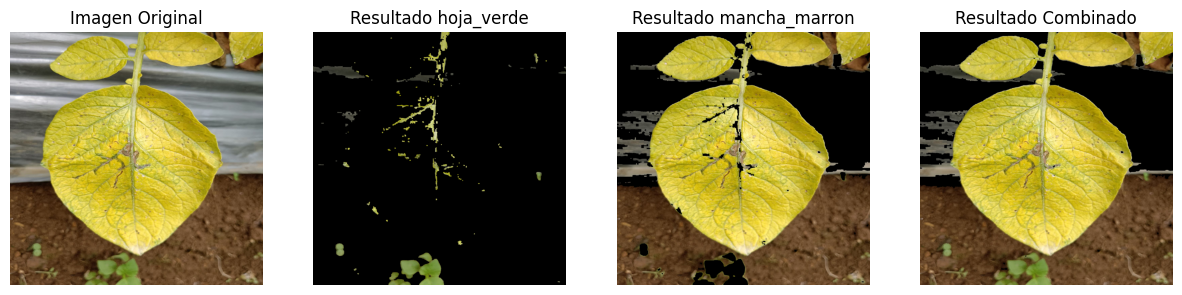

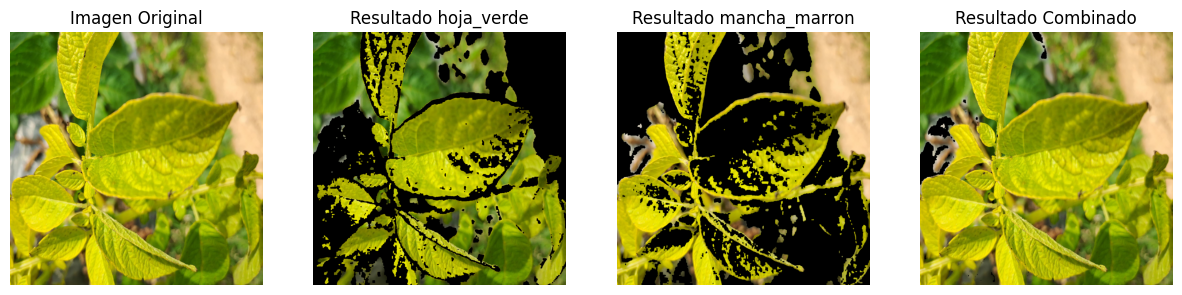

In [6]:
input_image_path = '../data/raw/Potato Leaf Disease Dataset in Uncontrolled Environment/Nematode'
resultados = procesar_imagenes_aleatorias1(input_image_path, rangos_colores)

In [7]:
def procesar_imagenes_aleatorias(carpeta_principal, rangos_colores, n=2):
    resultados = {}
    
    # Obtener todas las subcarpetas (categorías) en la carpeta principal
    categorias = [d for d in os.listdir(carpeta_principal) if os.path.isdir(os.path.join(carpeta_principal, d))]
    
    for categoria in categorias:
        print(f"Procesando categoría: {categoria}")
        carpeta_categoria = os.path.join(carpeta_principal, categoria)
        
        # Listar imágenes en la carpeta de la categoría
        imagenes = [f for f in os.listdir(carpeta_categoria) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        
        # Seleccionar n imágenes al azar
        imagenes_seleccionadas = random.sample(imagenes, min(n, len(imagenes)))
        
        # Procesar las imágenes seleccionadas
        resultados_categoria = []
        for imagen in imagenes_seleccionadas:
            ruta_imagen = os.path.join(carpeta_categoria, imagen)
            print(f"  Procesando imagen: {imagen}")
            
            # Llamar a la función segmentar_colores
            resultado_imagen = segmentar_colores(ruta_imagen, rangos_colores)
            resultados_categoria.append(resultado_imagen)
        
        resultados[categoria] = resultados_categoria
    
    return resultados

Procesando categoría: Bacteria
  Procesando imagen: 20230816_140934.jpg


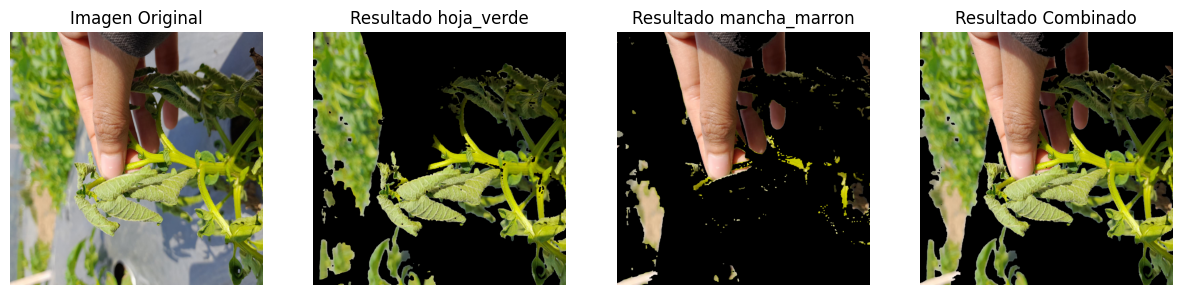

  Procesando imagen: 20230815_113527.jpg


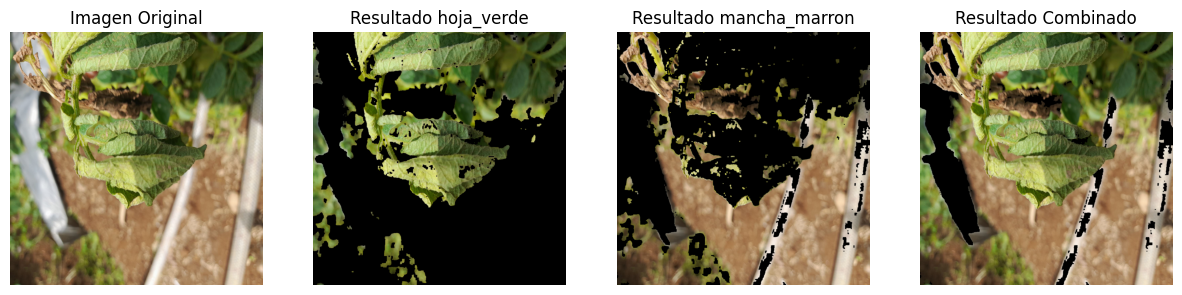

Procesando categoría: Fungi
  Procesando imagen: 20230816_083544.jpg


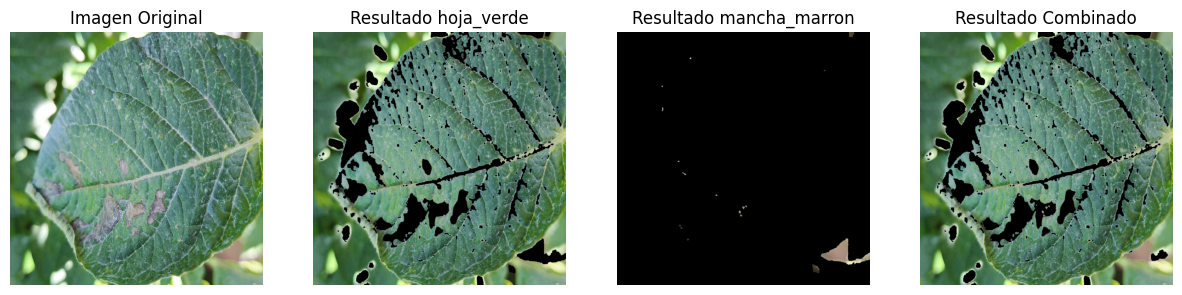

  Procesando imagen: IMG_9460.JPG


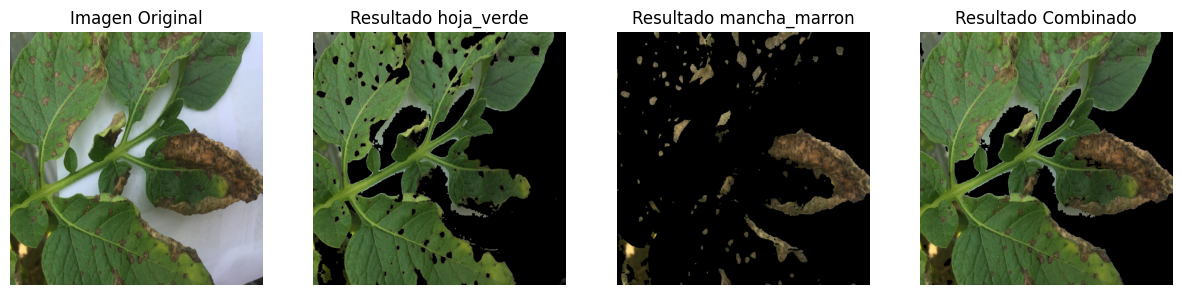

Procesando categoría: Healthy
  Procesando imagen: 20230816_121144.jpg


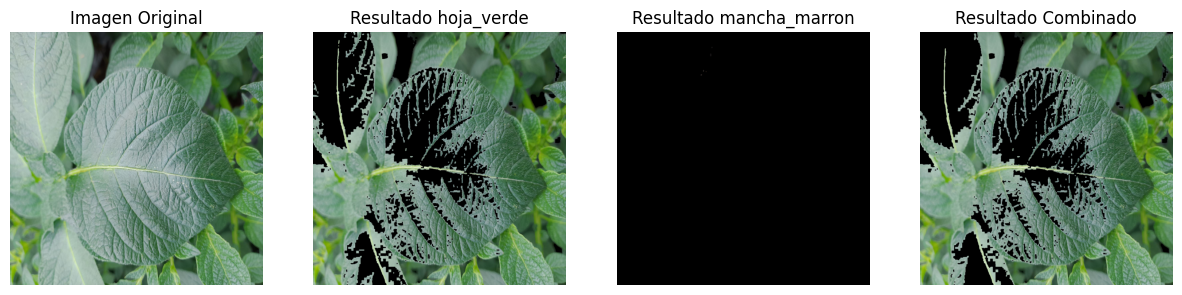

  Procesando imagen: 20230922_155838.jpg


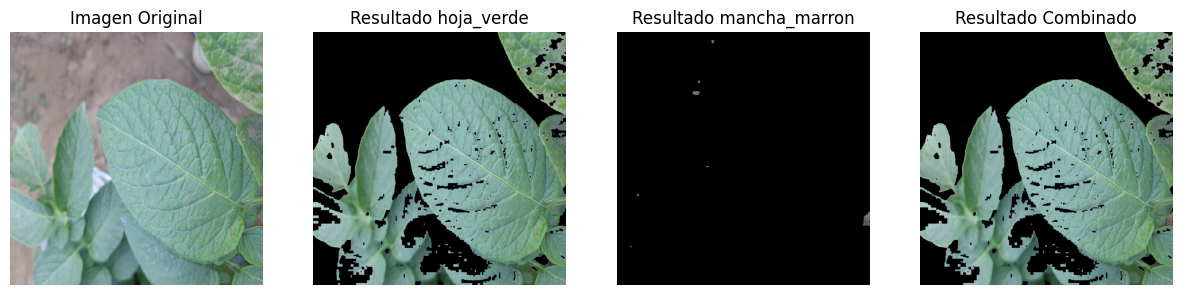

Procesando categoría: Nematode
  Procesando imagen: 20230816_121614.jpg


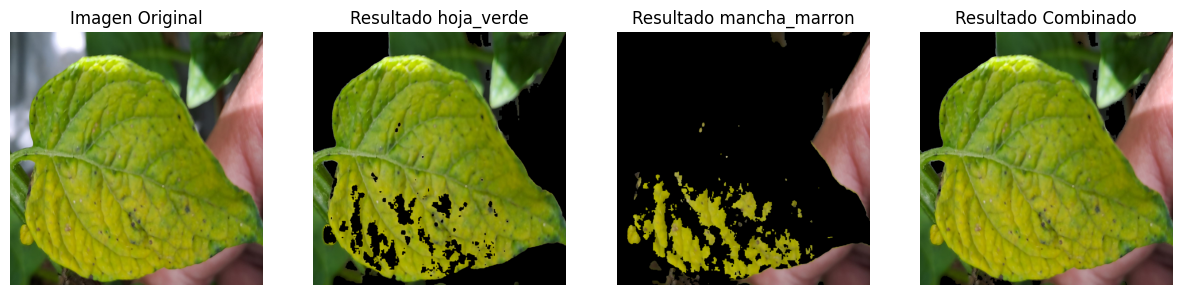

  Procesando imagen: IMG_0302.JPG


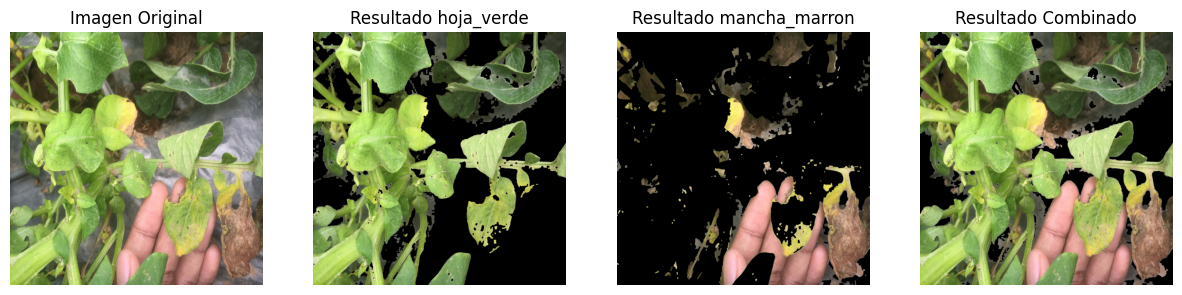

Procesando categoría: Pest
  Procesando imagen: IMG_4806.JPG


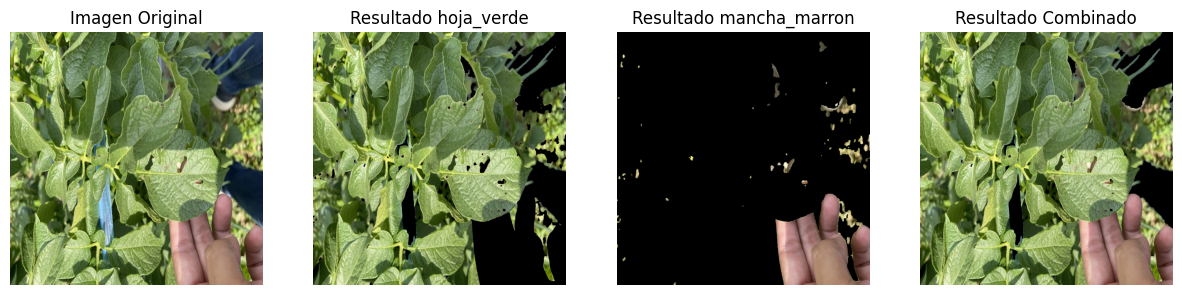

  Procesando imagen: 20230816_140322.jpg


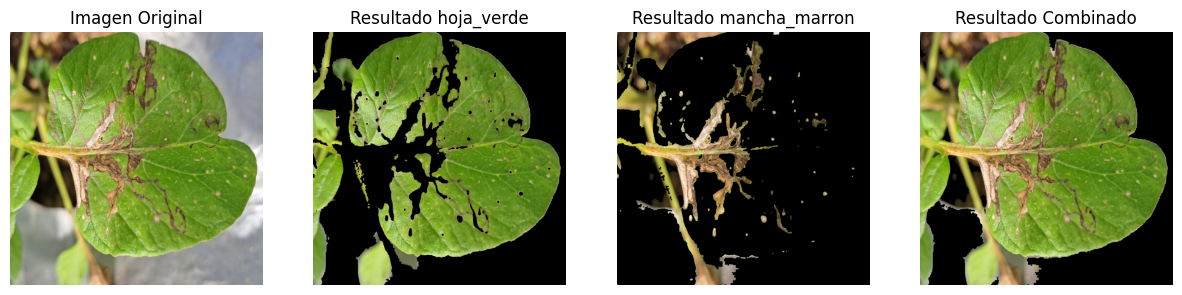

Procesando categoría: Phytopthora
  Procesando imagen: 20230802_124932.jpg


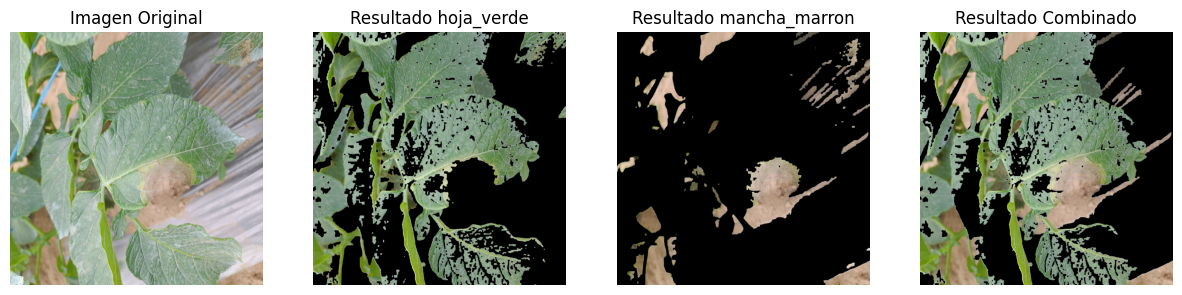

  Procesando imagen: IMG_0837.JPG


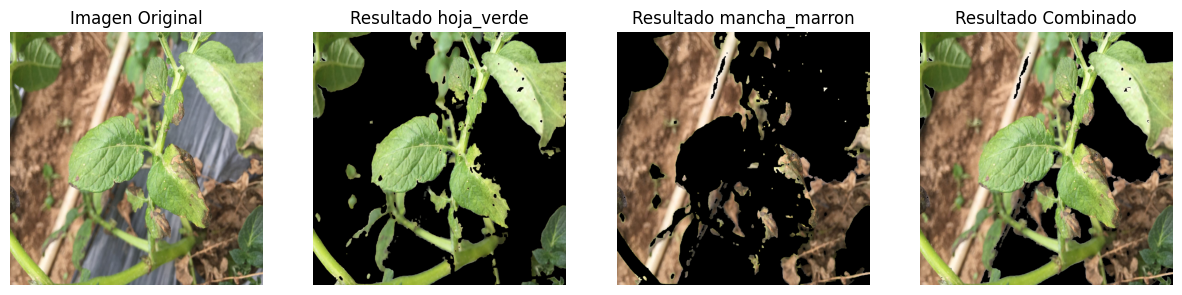

Procesando categoría: Virus
  Procesando imagen: IMG_0865.JPG


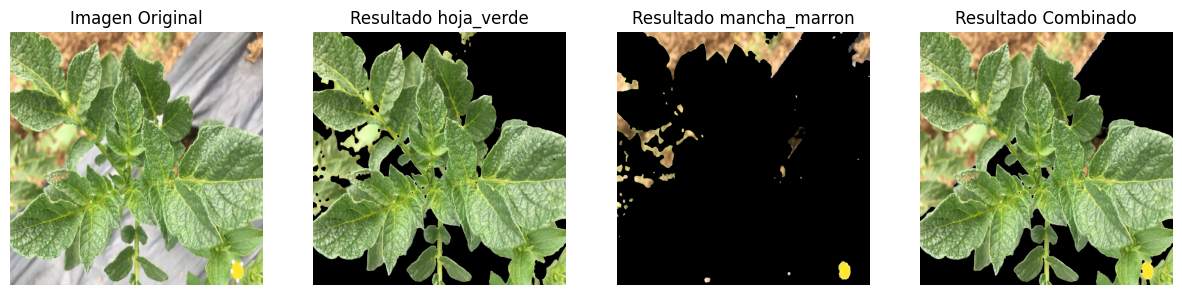

  Procesando imagen: 20230815_150450.jpg


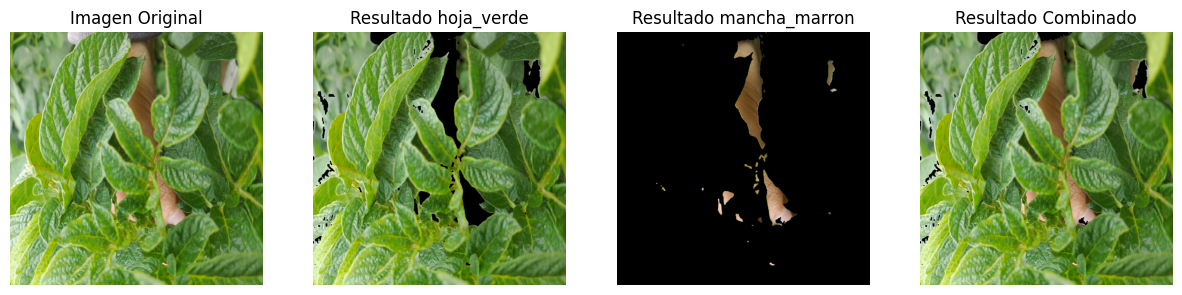

In [8]:
input_image_path = '../data/raw/Potato Leaf Disease Dataset in Uncontrolled Environment'
resultados = procesar_imagenes_aleatorias(input_image_path, rangos_colores)


In [9]:
def mostrar_imagen(titulos, imagenes):
    fig, axs = plt.subplots(1, len(imagenes), figsize=(12, 4))
    for i, (titulo, imagen) in enumerate(zip(titulos, imagenes)):
        if len(imagen.shape) == 2:
            axs[i].imshow(imagen, cmap='gray')
        else:
            axs[i].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        axs[i].set_title(titulo)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def segmentar_colores(imagen_ruta, rangos_colores):
    # Cargar la imagen usando PIL
    imagen_pil = Image.open(imagen_ruta)
    
    # Convertir la imagen PIL a un array numpy compatible con OpenCV
    imagen = cv2.cvtColor(np.array(imagen_pil), cv2.COLOR_RGB2BGR)
    
    # Convertir la imagen a espacio de color HSV
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Crear máscara para detectar el tono de piel (ajustar según sea necesario)
    piel_bajo = np.array([0, 20, 70])
    piel_alto = np.array([20, 255, 255])
    mascara_piel = cv2.inRange(imagen_hsv, piel_bajo, piel_alto)
    
    # Invertir la máscara de piel para obtener todo excepto la piel
    mascara_no_piel = cv2.bitwise_not(mascara_piel)
    
    resultados = {}
    mascaras = []
    
    titulos = ["Imagen Original"]
    imagenes = [imagen]

    for nombre_mascara, rangos in rangos_colores.items():
        mascara_combinada = np.zeros(imagen.shape[:2], dtype=np.uint8)
        for bajo, alto in rangos:
            mascara = cv2.inRange(imagen_hsv, np.array(bajo), np.array(alto))
            mascara_combinada = cv2.bitwise_or(mascara_combinada, mascara)
        
        # Aplicar la máscara de no-piel
        mascara_combinada = cv2.bitwise_and(mascara_combinada, mascara_no_piel)
        
        # Aplicar operaciones morfológicas
        kernel = np.ones((5,5), np.uint8)
        mascara_clean = cv2.morphologyEx(mascara_combinada, cv2.MORPH_OPEN, kernel)
        mascara_clean = cv2.morphologyEx(mascara_clean, cv2.MORPH_CLOSE, kernel)
        
        mascaras.append(mascara_clean)
        
        resultado = cv2.bitwise_and(imagen, imagen, mask=mascara_clean)
        resultados[nombre_mascara] = resultado
        
        titulos.append(f'Resultado {nombre_mascara}')
        imagenes.append(resultado)

    mascara_total = np.zeros(imagen.shape[:2], dtype=np.uint8)
    for mascara in mascaras:
        mascara_total = cv2.bitwise_or(mascara_total, mascara)
    
    # Encontrar el contorno más grande (asumiendo que es la hoja principal)
    contornos, _ = cv2.findContours(mascara_total, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contornos:
        contorno_max = max(contornos, key=cv2.contourArea)
        mascara_hoja = np.zeros(mascara_total.shape, np.uint8)
        cv2.drawContours(mascara_hoja, [contorno_max], -1, 255, -1)
        
        # Aplicar la máscara de la hoja principal
        mascara_total = cv2.bitwise_and(mascara_total, mascara_hoja)
    
    # Aplicar la máscara de no-piel al resultado final
    mascara_total = cv2.bitwise_and(mascara_total, mascara_no_piel)
    
    resultado_combinado = cv2.bitwise_and(imagen, imagen, mask=mascara_total)
    resultados["combinado"] = resultado_combinado

    titulos.append("Resultado Combinado")
    imagenes.append(resultado_combinado)

    mostrar_imagen(titulos, imagenes)
    
    return resultados

In [10]:
rangos_colores = {
    'hoja_verde': [([35, 30, 30], [85, 255, 255])],
    'mancha_marron': [([10, 50, 20], [30, 255, 200])]
}

Procesando categoría: Daños por nematodos
  Procesando imagen: imagen_1001.jpg


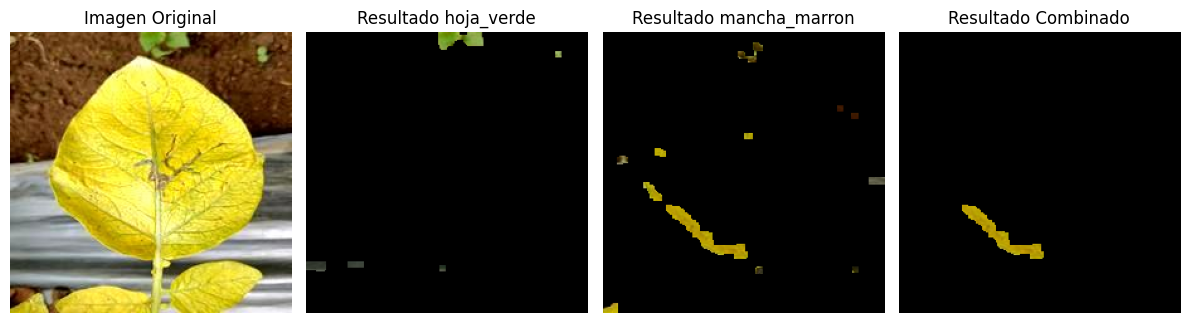

  Procesando imagen: imagen_0834.jpg


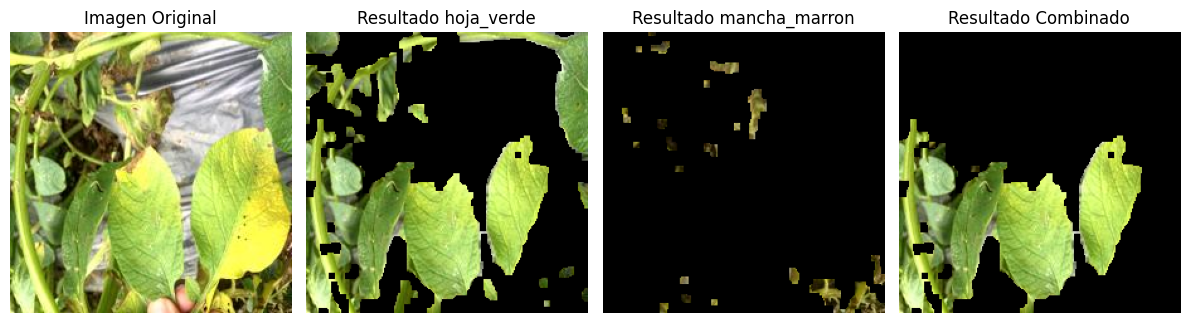

Procesando categoría: Daños por plagas
  Procesando imagen: imagen_0504.jpg


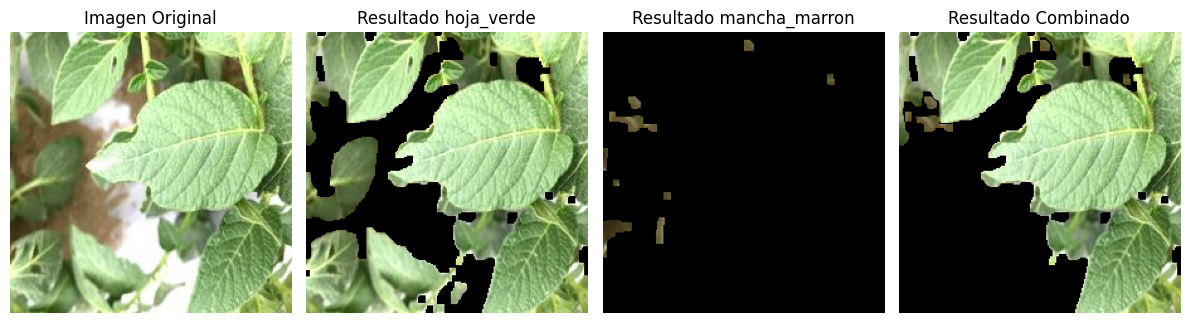

  Procesando imagen: imagen_0436.jpg


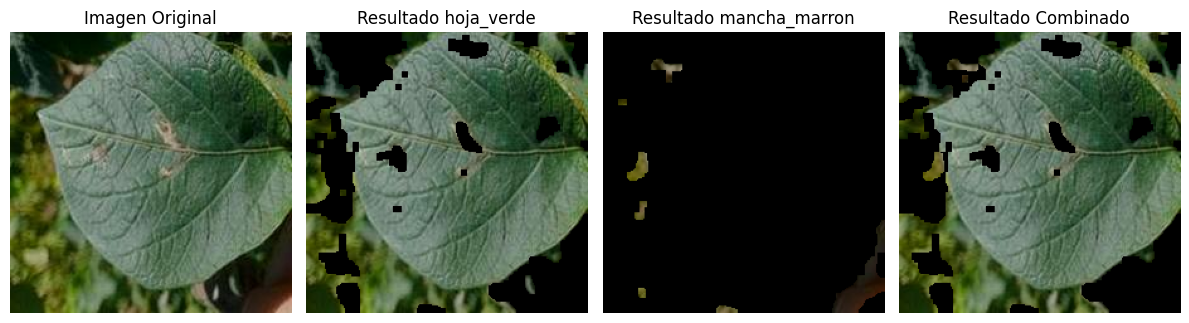

Procesando categoría: Enfermedades bacterianas
  Procesando imagen: imagen_0174.jpg


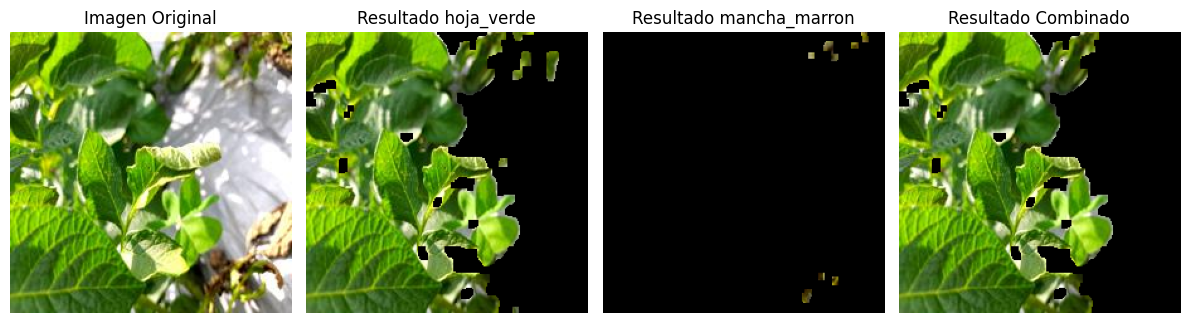

  Procesando imagen: imagen_0812.jpg


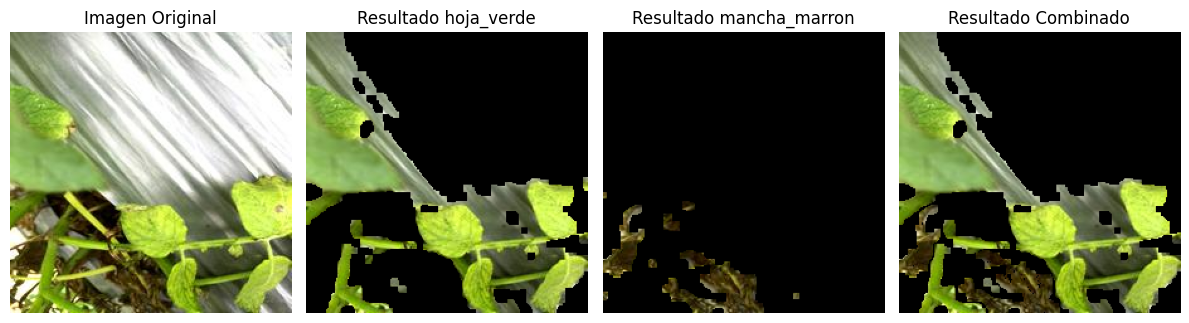

Procesando categoría: Enfermedades fúngicas
  Procesando imagen: imagen_1221.jpg


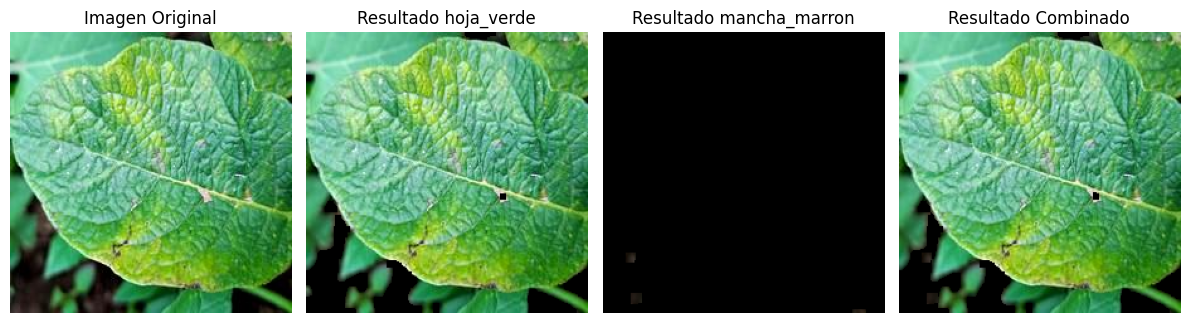

  Procesando imagen: imagen_0531.jpg


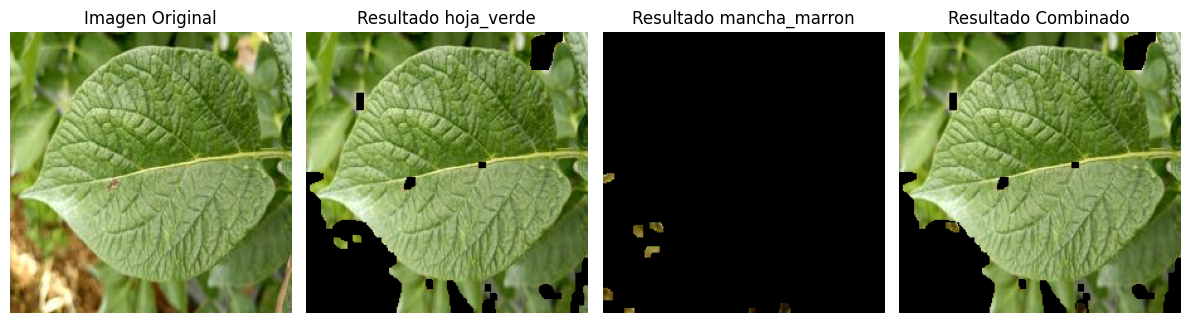

Procesando categoría: Enfermedades virales
  Procesando imagen: imagen_1030.jpg


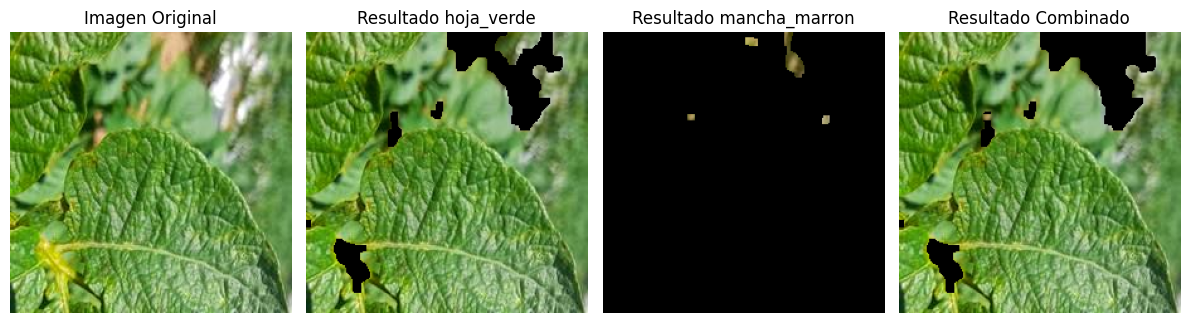

  Procesando imagen: imagen_0058.jpg


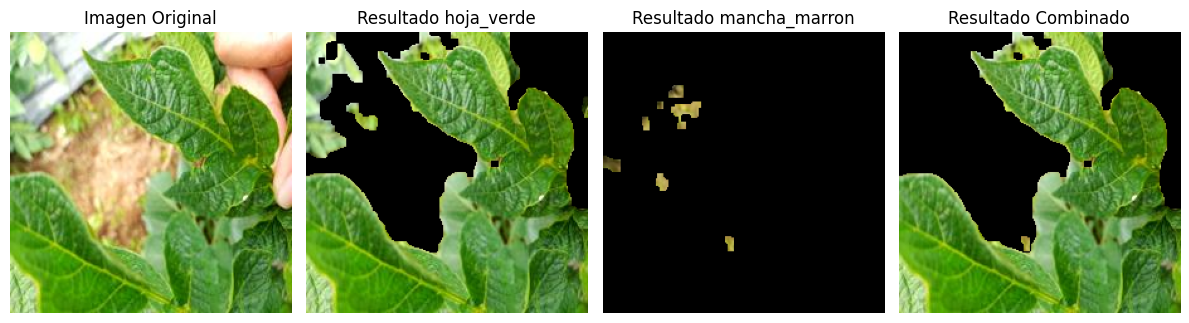

Procesando categoría: Salud
  Procesando imagen: imagen_0582.jpg


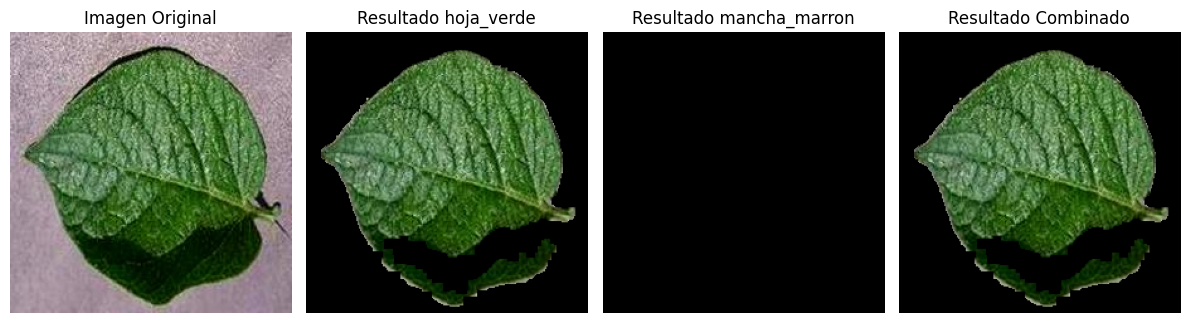

  Procesando imagen: imagen_1143.jpg


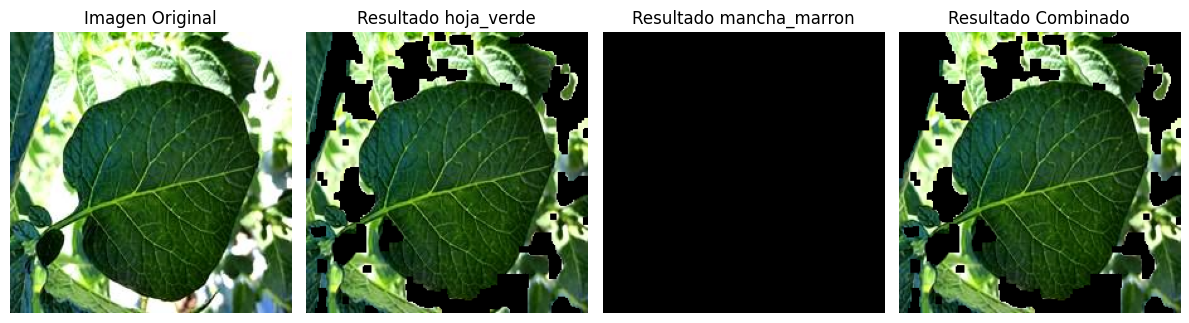

Procesando categoría: Tizón tardío (Phytophthora)
  Procesando imagen: imagen_0093.jpg


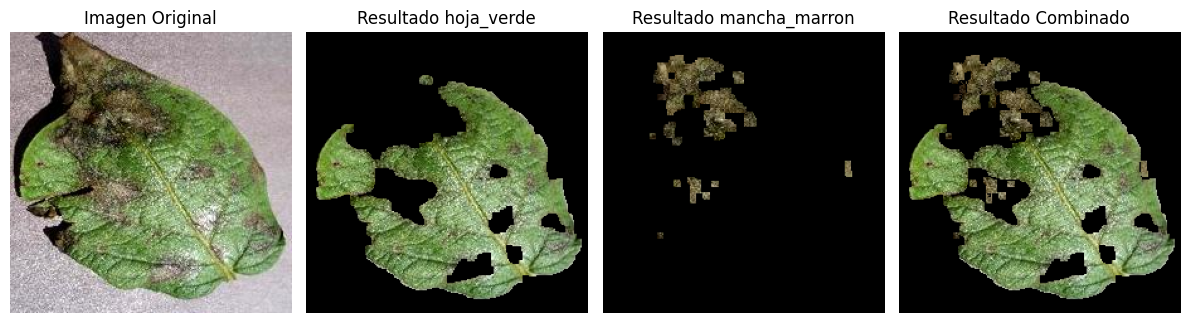

  Procesando imagen: imagen_0988.jpg


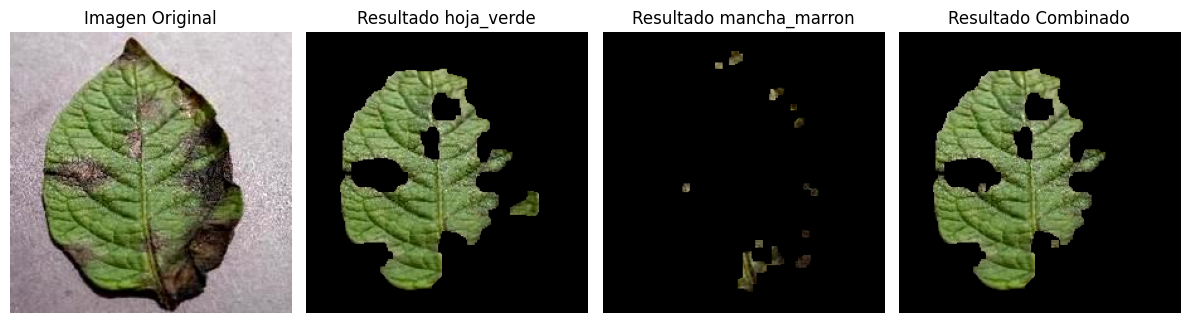

Procesando categoría: Tizón temprano
  Procesando imagen: imagen_0010.jpg


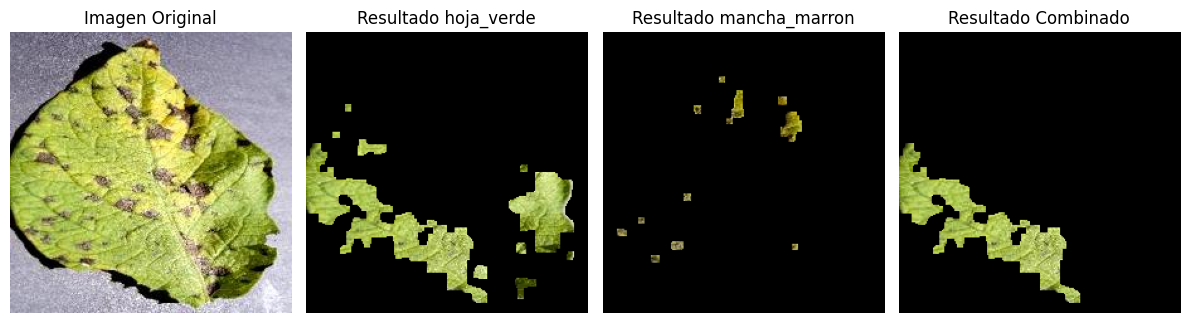

  Procesando imagen: imagen_0070.jpg


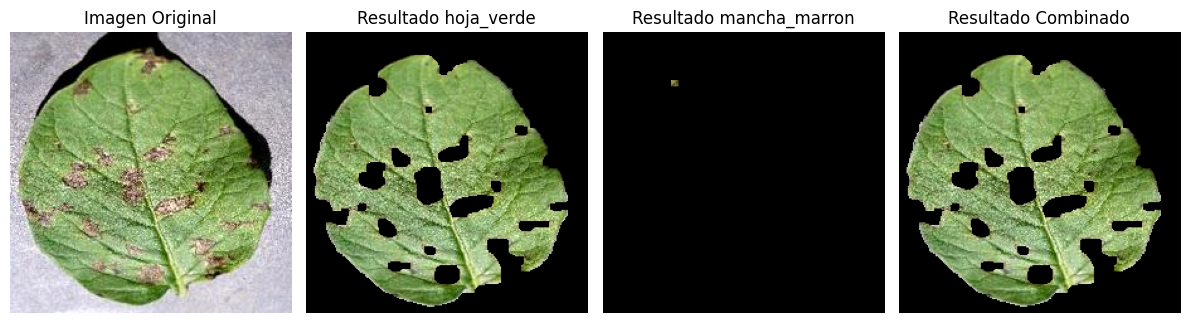

In [11]:
input_image_path = '../data/processed/preprocessed_potato_leaf'
resultados = procesar_imagenes_aleatorias(input_image_path, rangos_colores)